# Sentiment Analysis

This notebook describes the steps for building a sentiment analysis model. This model will read the Sentiment140 Twitter data, and learn what <b>positive</b> and <b>negative</b> sentiments look like. The model will perform a binary classification on the sentences and will classify them as expressing either positive or negative sentiment. It will then perform the same classification for a new, unseend statement.

The following work will look fairly standard to anyone having trained machine learning models using python Jupyter notebooks. The CML platform provides a fully capable Jupyter notebook environment that data scientists know and love.

In this process, you will learn how to train a Neural Network model using Tensorflow and Keras, for performing sentiment analysis on text data, which is one of the most common use cases in Natural Language Processing.

We will use the [Sentiment140](http://help.sentiment140.com/home) data, compiled by the Stanford team.

These steps can also be found on the three Python files in this project, namely, <i>01_read_data.py</i>, <i>02_pre-processing_and_model_training.py</i> and <i>03_sentiment_prediction.py</i>.

## Install and Import Tensorflow

Before importing the following packages, ensure they are installed properly. If not, install them first using either a <i>requirements.txt</i> file, or directly using <b>pip</b>.

In [1]:
#!pip3 install --upgrade pip
#!pip --version
#!pip3 install tensorflow

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
import csv
import json
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

## Download data

This section shows the following:

1. Download Sentiment140 training data from the Stanford url

2. Extract the data files

3. Remove the LATIN1 encoding, and ensure only the UTF-8 encoded data is being used. This is done to avoid problems while using a Python CSV Reader.

In [3]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
# Move the file to the "data" folder and rename it to 'sentiment140_training_and_test_data.zip'

--2020-09-15 09:35:05--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2020-09-15 09:35:06--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata 100%[===================>]  77.59M  1.65MB/s    in 9.9s    

2020-09-15 09:35:16 (7.85 MB/s) - ‘trainingandtestdata.zip’ saved [81363704/81363704]



In [4]:
##Unzip
import zipfile
with zipfile.ZipFile("temp_data/sentiment140_training_and_test_data.zip","r") as zip_ref:
    zip_ref.extractall("temp_data/sentiment140_unzipped")

In [5]:
##Remove the LATIN1 encoding
!iconv -f LATIN1 -t UTF8 data/sentiment140_unzipped/training.1600000.processed.noemoticon.csv -o data/sentiment140_cleaned.csv


## Data Exploration

The training dataset contains 1600000 samples, where each row contains the following fields:

0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

1 - the id of the tweet

2 - the date of the tweet

3 - the quer

4 - the user that tweeted

5 - the text of the tweet

Going forward, we would only require the text and the label for every tweet. We can drop the rest of the fields for our model building process. Before that, it is important to understand if the dataset is balanced or not. To do this, we'll count the number for positive and negative labels. If the two numbers have a huge difference, it is important to balance the data, in order to avoid <b>bias</b> in the training.

In [8]:
count_positive = 0
count_neutral = 0
count_negative = 0

with open("../temp_data/sentiment140_unzipped/clean_data.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        label_only=row[0]
        if label_only=='0':
            count_negative = count_negative + 1
        elif label_only=='2':
            count_neutral = count_neutral + 1
        else:
            count_positive = count_positive + 1

print("Positive : " + str(count_positive))
print("Negative : " + str(count_negative))
print("Neutral : " + str(count_neutral))

Positive : 800000
Negative : 800000
Neutral : 0


In this case, the dataset is perfectly balanced, as we have equal number of positive and negative tweets. Also, do note that we haven't encountered a single tweet with a <i>Neutral</i> sentiment. So, let's convert the label field entries from 0 and 4 to 0 and 1 respectively, for Negative and Positive sentiments. Since the data is structured for a <b>binary classification</b> problem, we will train our model for a 0 or 1 sentiment prediction, thereby elimination the risk of the model interpreting this as a <b>multi class classification</b> problem.

In [9]:
num_sentences = 0
corpus = []

with open("../temp_data/sentiment140_unzipped/clean_data.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        text_and_label=[]
        text_and_label.append(row[5])
        label_only=row[0]
        if label_only=='0':
            text_and_label.append(0)
        else:
            text_and_label.append(1)
        num_sentences = num_sentences + 1
        corpus.append(text_and_label)

We now have a <i>corpus</i>, which is a list of lists. Here, each list, or each record is a combination of the tweet text and the associated training label (0 or 1). Here's an example of one entry from the corpus:

In [10]:
print(num_sentences)
print(len(corpus))
print(corpus[20])

1600000
1600000
["@alydesigns i was out most of the day so didn't get much done ", 0]


Ensure there are no labels other than 0 and 1 in the corpus:

In [11]:
all_labels = [item[1] for item in corpus]
unique_labels = set(all_labels)
unique_labels

{0, 1}

## Data Preprocessing

### Tokenization, Padding and Train-test split

This step is the pre-processing phase where we perform the <b>Tokenization</b>, <b>Padding</b> and then create the <b>Embedding</b> matrix. For this particular example, we're limiting the maximum length of the tweets to 16. Also, define all the parameters we'll be using in the data preparation process.

In [12]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=1600000
test_portion=.1

In this scenario, we’re first splitting each sentence into individual words, and assigning a unique integer to every word. This process is called Tokenization. Once you have a word index like this, it’s easier to pick the embedding vector, for a specified integer. This adds more semantic meaning to our training data. We also do a couple of things like, defining a fixed maximum length for all sentences, and then “padding” every sentence with a ‘0’, to align with the maximum length decided. We’ll then split our data between <b>training</b> and <b>validation</b> sets.

In [13]:
all_sentences=[]
all_labels=[]
random.shuffle(corpus)
for x in range(training_size):
    all_sentences.append(corpus[x][0])
    all_labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sent_sequences = tokenizer.texts_to_sequences(all_sentences)
padded_sent = pad_sequences(sent_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded_sent[0:split]
training_sequences = padded_sent[split:training_size]
test_labels = all_labels[0:split]
training_labels = all_labels[split:training_size]

In [14]:
print(type(training_sequences))
print(type(training_labels))

<class 'numpy.ndarray'>
<class 'list'>


In [15]:
print(training_sequences.shape)
print(len(training_labels))
print(test_sequences.shape)
print(len(test_labels))

(1440000, 16)
1440000
(160000, 16)
160000


The final training and validation set sizes are 1440000 and 160000 respectively.

### GloVe Embeddings

For building the word embeddings, we'll use the pre-trained embeddings from [GloVe](https://nlp.stanford.edu/projects/glove/). GloVe is an <i>unsupervised</i> learning algorithm, designed by the Stanford NLP team. You can obtain vector representations for words in your dataset. We're using the 100 dimensional vectors, as defined earlier.

In [16]:
!wget http://nlp.stanford.edu/data/glove.6B.zip -O temp_data/embeddings/glove.6B.zip

--2020-09-15 09:39:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-09-15 09:39:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-09-15 09:39:32--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘embeddings/glove.6B.zi

In [17]:
##Unzip
import zipfile
with zipfile.ZipFile("../temp_data/embeddings/glove.6B.zip","r") as zip_ref:
    zip_ref.extractall("../temp_data/embeddings/glove_6B")

In [18]:
embedding_dict = {};
with open('../temp_data/embeddings/glove_6B/glove.6B.100d.txt') as f:
    for item in f:
        embed_items = item.split();
        word = embed_items[0];
        word_vec = np.asarray(embed_items[1:], dtype='float32');
        embedding_dict[word] = word_vec;

embedding_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word);
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector;

In [19]:
embedding_matrix.shape

(690961, 100)

In [20]:
vocab_size

690960

In [21]:
##Examples from the word index
from itertools import islice

def take(n, iterable):
    return list(islice(iterable, n))

n_items = take(20, word_index.items())
print(n_items)

[('i', 1), ('to', 2), ('the', 3), ('a', 4), ('my', 5), ('and', 6), ('you', 7), ('is', 8), ('it', 9), ('in', 10), ('for', 11), ('of', 12), ('on', 13), ('me', 14), ('so', 15), ('have', 16), ('that', 17), ('but', 18), ("i'm", 19), ('just', 20)]


## Build Model and Train

In this phase, we build a Neural Network model using the Keras API from Tensorflow. This network has one <b>CNN</b> layer i.e. Convolutional Neural Network, and one <b>LSTM</b> (Long Short-Term Memory) layer. The LSTM is a special type of <i>Recurrent Neural Net</i>. LSTMs have a cell state for handling the long-term dependencies. With sequential data, such as lengthy sentences, it is required to carry some information from the beginning of the sentence to the end. And LSTMs have been found to work well with such data, because of its ability to carry the information well. We then train the model.

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Conv1D(32, 8, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           69096100  
_________________________________________________________________
conv1d (Conv1D)              (None, 9, 32)             25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 32)             0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                5

All these parameters and hyperparameters like optimization algorithms, learning rate, number of epochs, batch training, all of these are really experimental. You can work with whatever gives you good results. In our case, we managed to have an accuracy of 78% with 100 epochs and training in batches.

In [23]:
num_epochs = 100
batch_size = 16000
history = model.fit(np.array(training_sequences), np.array(training_labels), batch_size=batch_size, epochs=num_epochs, validation_data=(np.array(test_sequences), np.array(test_labels)), verbose=2)

print("Training Complete!")

Epoch 1/100
90/90 - 6s - loss: 0.6216 - acc: 0.6530 - val_loss: 0.5605 - val_acc: 0.7086
Epoch 2/100
90/90 - 5s - loss: 0.5596 - acc: 0.7139 - val_loss: 0.5303 - val_acc: 0.7307
Epoch 3/100
90/90 - 5s - loss: 0.5413 - acc: 0.7281 - val_loss: 0.5182 - val_acc: 0.7400
Epoch 4/100
90/90 - 5s - loss: 0.5308 - acc: 0.7362 - val_loss: 0.5104 - val_acc: 0.7448
Epoch 5/100
90/90 - 5s - loss: 0.5242 - acc: 0.7411 - val_loss: 0.5057 - val_acc: 0.7483
Epoch 6/100
90/90 - 5s - loss: 0.5199 - acc: 0.7444 - val_loss: 0.5012 - val_acc: 0.7512
Epoch 7/100
90/90 - 5s - loss: 0.5163 - acc: 0.7474 - val_loss: 0.4983 - val_acc: 0.7532
Epoch 8/100
90/90 - 5s - loss: 0.5134 - acc: 0.7495 - val_loss: 0.4966 - val_acc: 0.7537
Epoch 9/100
90/90 - 5s - loss: 0.5114 - acc: 0.7509 - val_loss: 0.4949 - val_acc: 0.7550
Epoch 10/100
90/90 - 5s - loss: 0.5086 - acc: 0.7525 - val_loss: 0.4926 - val_acc: 0.7565
Epoch 11/100
90/90 - 5s - loss: 0.5073 - acc: 0.7535 - val_loss: 0.4913 - val_acc: 0.7568
Epoch 12/100
90/90 

90/90 - 5s - loss: 0.4799 - acc: 0.7710 - val_loss: 0.4734 - val_acc: 0.7701
Epoch 93/100
90/90 - 5s - loss: 0.4801 - acc: 0.7716 - val_loss: 0.4751 - val_acc: 0.7696
Epoch 94/100
90/90 - 5s - loss: 0.4800 - acc: 0.7713 - val_loss: 0.4746 - val_acc: 0.7691
Epoch 95/100
90/90 - 5s - loss: 0.4795 - acc: 0.7718 - val_loss: 0.4726 - val_acc: 0.7707
Epoch 96/100
90/90 - 5s - loss: 0.4794 - acc: 0.7715 - val_loss: 0.4738 - val_acc: 0.7700
Epoch 97/100
90/90 - 5s - loss: 0.4797 - acc: 0.7715 - val_loss: 0.4735 - val_acc: 0.7701
Epoch 98/100
90/90 - 5s - loss: 0.4794 - acc: 0.7714 - val_loss: 0.4734 - val_acc: 0.7699
Epoch 99/100
90/90 - 5s - loss: 0.4801 - acc: 0.7711 - val_loss: 0.4744 - val_acc: 0.7697
Epoch 100/100
90/90 - 5s - loss: 0.4793 - acc: 0.7716 - val_loss: 0.4736 - val_acc: 0.7702
Training Complete!


### Plot Accuracy and Loss

In [24]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

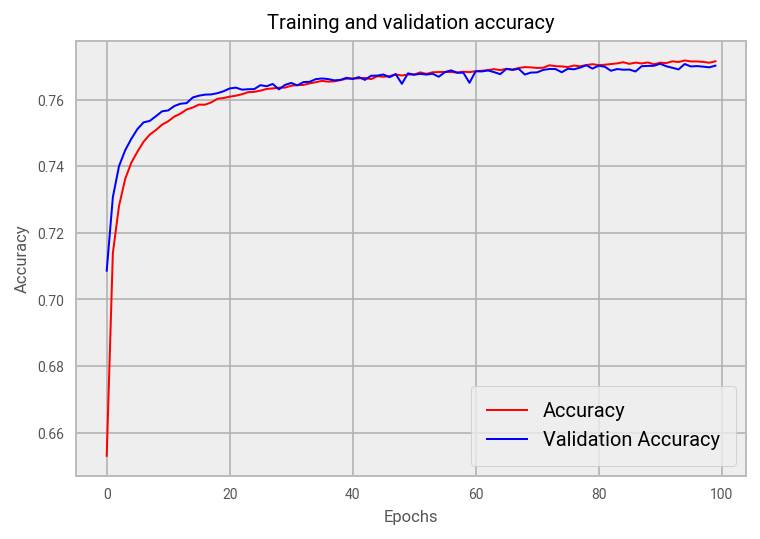

In [25]:
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

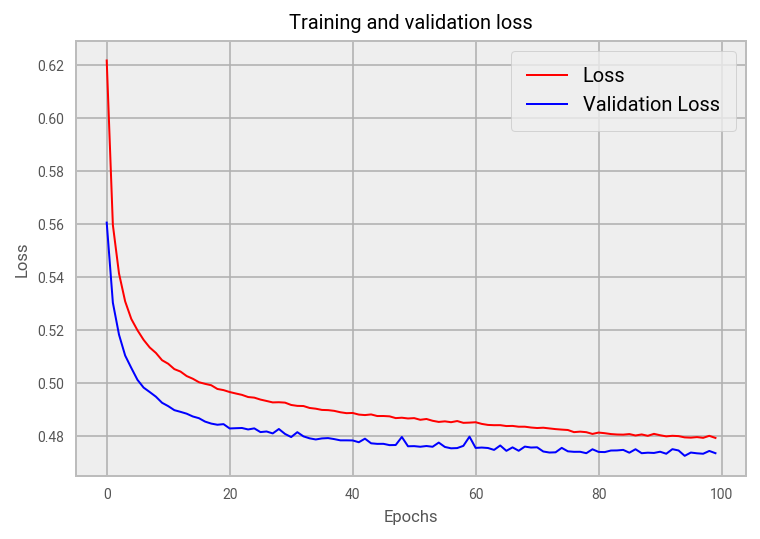

In [26]:
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

### Save the Model

In [27]:
import h5py
model.save('saved_models/model_sentiment140.h5')

In [28]:
# Recreate the exact same model, including its weights and the optimizer
model_h5 = tf.keras.models.load_model('saved_models/model_sentiment140.h5')

# Show the model architecture
model_h5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           69096100  
_________________________________________________________________
conv1d (Conv1D)              (None, 9, 32)             25632     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 32)             0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                5

## Model Evaluation

#### Overall Training and Test accuracies

In [29]:
loss, acc = model.evaluate(np.array(training_sequences), np.array(training_labels), verbose=0)
print('Training Accuracy: %.2f%% ' % (acc*100))

Training Accuracy: 78.20% 


In [30]:
loss, acc = model.evaluate(np.array(test_sequences), np.array(test_labels), verbose=0)
print('Test Accuracy: %.2f%% ' % (acc*100))

Test Accuracy: 77.02% 


#### Sentiment Prediction Examples

Before testing the model for example predictions, the input sentences need to be pre-processed and made ready for the model in the same format as the training data, i.e. tokenized and padded. To evaluate the predictive capability of the trained model, we do the following:

Preprocess the records using the same Tokenizer as the training data

Use the preprocessed data as the input vectors of the model, and compute the output vectors i.e. the prediction classes and the confidence.

In this example, the confidence value is used to set a threshold for performing the classification. If the predicted probability is found to be less than 0.5, we classify the statement as "negative", and as "positive" if the value is found to be 0.5 or above. We later display that value in percentage, as the <i>confidence</i> value for our model prediction.

In [31]:
def text_prep(sent):
    print("Input sentence : " + sent)
    sent = np.array([sent])
    token_list = tokenizer.fit_on_texts(sent)
    
    sequences = tokenizer.texts_to_sequences(sent)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    return padded

In [32]:
def predict_sentiment(sent):
    test_example = text_prep(sent)
    pred_conf = model.predict(test_example)
    pred_class = (model.predict(test_example) > 0.5).astype("int32")
    if pred_class[0][0]==0:
        sentiment = 'Negative'
        conf = 100 - (pred_conf[0][np.argmax(pred_conf)] * 100)
    else:
        sentiment = 'Positive'
        conf = pred_conf[0][np.argmax(pred_conf)] * 100
    print("%s sentiment; %.2f%% confidence" % (sentiment, conf))

In [33]:
predict_sentiment("What a great and beautiful day")

Input sentence : What a great and beautiful day
Positive sentiment; 99.35% confidence


In [34]:
predict_sentiment("I'm having a terrible day!")

Input sentence : I'm having a terrible day!
Negative sentiment; 98.91% confidence


In [35]:
predict_sentiment("I'm having an awesome day")

Input sentence : I'm having an awesome day
Positive sentiment; 94.75% confidence


In [36]:
predict_sentiment("Ive had a long day!")

Input sentence : Ive had a long day!
Negative sentiment; 57.38% confidence


In [37]:
predict_sentiment("This is a bad example")

Input sentence : This is a bad example
Negative sentiment; 90.50% confidence


In [38]:
predict_sentiment("This is the worst ice-cream Ive had")

Input sentence : This is the worst ice-cream Ive had
Negative sentiment; 88.17% confidence


In [39]:
predict_sentiment("This government is a failure!")

Input sentence : This government is a failure!
Negative sentiment; 67.76% confidence


In [40]:
predict_sentiment("This government is a bad failure!")

Input sentence : This government is a bad failure!
Negative sentiment; 93.42% confidence


In [41]:
predict_sentiment("They lost the elections!")

Input sentence : They lost the elections!
Negative sentiment; 95.42% confidence


In [42]:
predict_sentiment("They won the elections!")

Input sentence : They won the elections!
Positive sentiment; 70.73% confidence


In [43]:
predict_sentiment("It's a bittersweet experience!")

Input sentence : It's a bittersweet experience!
Positive sentiment; 79.44% confidence


In [44]:
predict_sentiment("I wish this gets over soon!")

Input sentence : I wish this gets over soon!
Negative sentiment; 92.81% confidence
